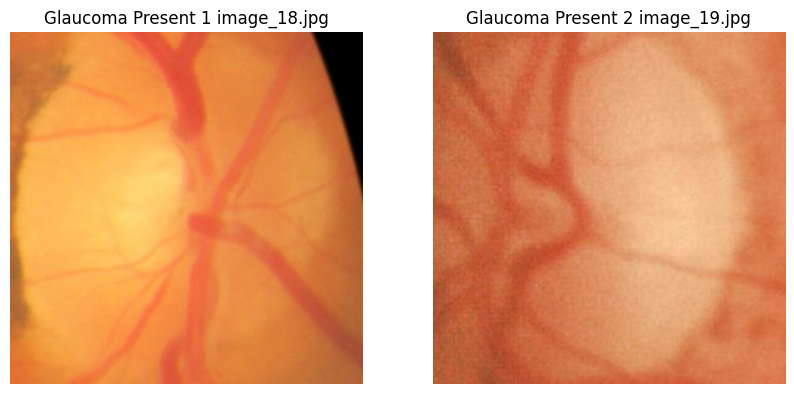

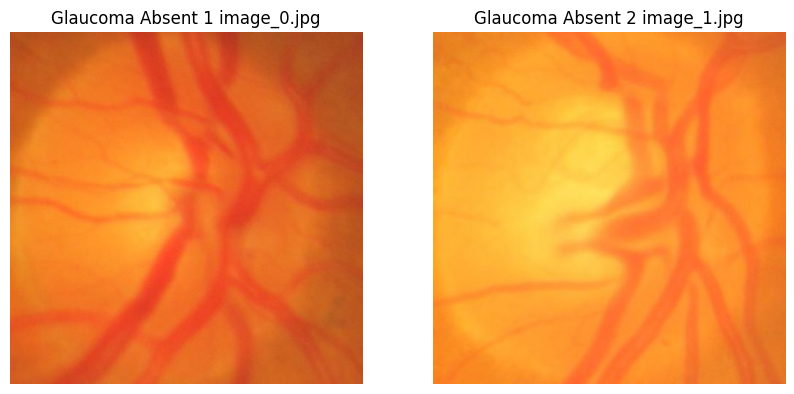

In [2]:
import pandas as pd
import cv2
import os
import matplotlib.pyplot as plt

# Define paths
csv_path = "/kaggle/input/glaucoma-datasets/G1020/G1020.csv"
image_folder = "/kaggle/input/glaucoma-datasets/G1020/Images_Cropped/img"

# Load CSV
df = pd.read_csv(csv_path)

# Ensure column names are correct
image_column = df.columns[0]  # First column (image names)
label_column = df.columns[1]  # Second column (labels)

# Get first two images labeled 1 and first two labeled 0
glaucoma_present = df[df[label_column] == 1][image_column].iloc[:2].tolist()
glaucoma_absent = df[df[label_column] == 0][image_column].iloc[:2].tolist()

# Function to display images
def display_images(image_names, title):
    plt.figure(figsize=(10, 5))
    for i, image_name in enumerate(image_names):
        img_path = os.path.join(image_folder, image_name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB for correct display
        
        plt.subplot(1, 2, i + 1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"{title} {i+1} {image_name}")
    
    plt.show()

# Display images
display_images(glaucoma_present, "Glaucoma Present")
display_images(glaucoma_absent, "Glaucoma Absent")

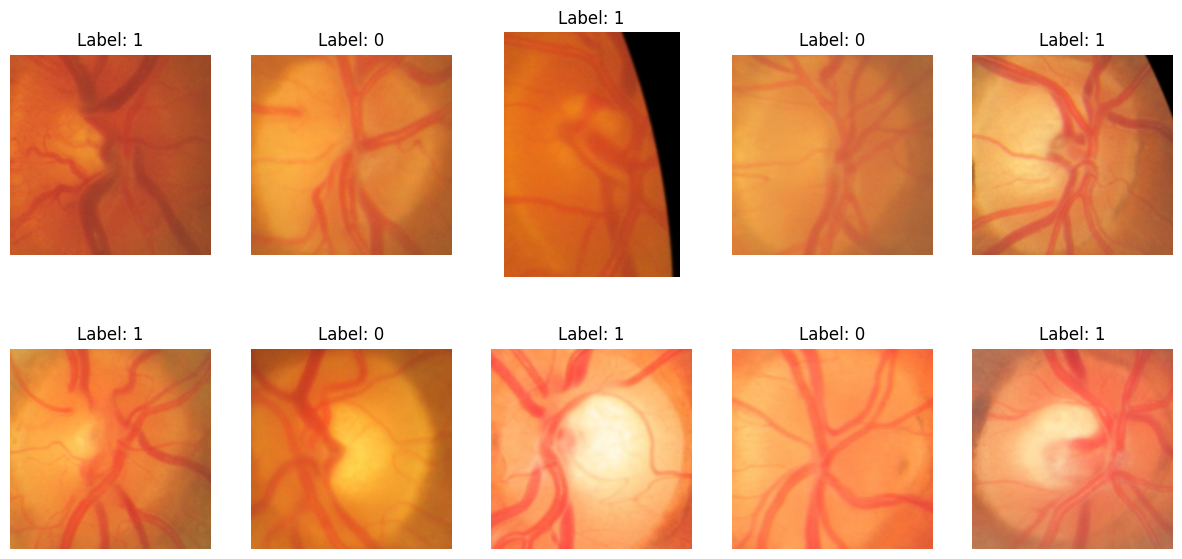

In [3]:
random_samples = df.sample(n=10, random_state=42)  # Set seed for reproducibility

# Function to display images
def display_images(image_list):
    plt.figure(figsize=(15, 7))
    
    for i, (image_name, label) in enumerate(zip(image_list[image_column], image_list[label_column])):
        img_path = os.path.join(image_folder, image_name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB for correct display
        
        plt.subplot(2, 5, i + 1)  # Arrange in 2 rows, 5 columns
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"Label: {label}")
    
    plt.show()

# Display images
display_images(random_samples)

In [ ]:
import torch
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms
import pandas as pd
import numpy as np

# First define the train/test split ratio
def create_data_loaders(csv_path, image_folder, batch_size=8, train_ratio=0.8):
    """
    Create train and test data loaders
    
    Args:
        csv_path (str): Path to CSV file with image names and labels
        image_folder (str): Path to folder containing images
        batch_size (int): Batch size for data loaders
        train_ratio (float): Ratio of data to use for training (0.0 to 1.0)
    
    Returns:
        train_loader, test_loader
    """
    # Define transforms
    train_transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
    ])
    
    # Test transform doesn't need augmentation
    test_transform = transforms.Compose([])
    
    # Create full dataset
    full_dataset = FundusDataset(csv_path, image_folder, transform=None)
    
    # Calculate lengths for split
    total_size = len(full_dataset)
    train_size = int(train_ratio * total_size)
    test_size = total_size - train_size
    
    # Split dataset
    train_dataset, test_dataset = random_split(
        full_dataset, 
        [train_size, test_size],
        generator=torch.Generator().manual_seed(42)  # For reproducibility
    )
    
    # Add transforms to the splits
    train_dataset.dataset.transform = train_transform
    test_dataset.dataset.transform = test_transform
    
    # Create data loaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2
    )
    
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2
    )
    
    return train_loader, test_loader

# Modified main execution code
if __name__ == "__main__":
    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # Define paths
    csv_path = "/kaggle/input/glaucoma-datasets/G1020/G1020.csv"  # Update with your actual path
    image_folder = "/kaggle/input/glaucoma-datasets/G1020/Images_Cropped/img"  # Update with your actual path
    
    # Create data loaders
    train_loader, test_loader = create_data_loaders(
        csv_path=csv_path,
        image_folder=image_folder,
        batch_size=8,
        train_ratio=0.8
    )
    
    print(f"Training batches: {len(train_loader)}")
    print(f"Testing batches: {len(test_loader)}")
    
    # Initialize model
    model = SimCLR().to(device)
    
    # Train model
    train_model(model, train_loader, epochs=5, save_path="simclr_model.pth")
    
    # Initialize visualizer with test loader
    visualizer = GlaucomaVisualizer(model, test_loader, device)
    
    # Generate visualizations
    visualizer.plot_roc_curve()
    visualizer.plot_confusion_matrix()
    
    # Evaluate model
    accuracy, probs, labels = evaluate_model(model, test_loader, device)
    print(f"Model Accuracy: {accuracy:.2f}%")
    
    # Optional: Visualize attention maps for a specific image
    example_image_path = "/kaggle/input/glaucoma-datasets/G1020/Images_Cropped/image_2530.jpg"  # Update with actual image path
    visualizer.visualize_attention_maps(example_image_path)

# Function to check data distribution
def check_data_distribution(csv_path):
    """Print distribution of labels in dataset"""
    df = pd.read_csv(csv_path)
    label_column = df.columns[1]  # Assuming second column contains labels
    
    # Get distribution
    distribution = df[label_column].value_counts()
    total = len(df)
    
    print("\nData Distribution:")
    for label, count in distribution.items():
        percentage = (count / total) * 100
        print(f"Class {label}: {count} images ({percentage:.2f}%)")
    
    return distribution

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.cluster import DBSCAN
import numpy as np
import pandas as pd
from timm import create_model
import cv2
import os
from PIL import Image

# Dataset class remains the same
class FundusDataset(Dataset):
    def __init__(self, csv_path, image_folder, transform=None):
        self.data = pd.read_csv(csv_path)
        self.image_folder = image_folder
        self.transform = transform
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        image_name = self.data.iloc[idx, 0]
        label = self.data.iloc[idx, 1]
        image_path = os.path.join(self.image_folder, image_name)
        image = preprocess_image(image_path)
        image = torch.tensor(image).permute(2, 0, 1)
        label = torch.tensor(label, dtype=torch.float32).unsqueeze(0)
        if self.transform:
            image = self.transform(image)
        return image, label

# Preprocessing function remains the same
def preprocess_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    l = clahe.apply(l)
    lab = cv2.merge((l, a, b))
    image = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)
    
    image = cv2.resize(image, (224, 224))
    image = image.astype(np.float32) / 255.0
    return image

# Modified SimCLR model with classification head
class SimCLR(nn.Module):
    def __init__(self, base_model='vit_base_patch16_224', out_dim=128):
        super(SimCLR, self).__init__()
        self.encoder = create_model(base_model, pretrained=True, num_classes=0)
        self.projection_head = nn.Sequential(
            nn.Linear(self.encoder.num_features, 512),
            nn.ReLU(),
            nn.Linear(512, out_dim)
        )
        # Add classification head
        self.classification_head = nn.Sequential(
            nn.Linear(out_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1)  # Output single value for binary classification
        )
    
    def forward(self, x, return_features=False):
        features = self.encoder(x)
        projections = self.projection_head(features)
        if return_features:
            return projections
        classifications = self.classification_head(projections)
        return classifications

# Modified training function
def train_model(model, dataloader, epochs=10, lr=1e-4, save_path="model.pth"):
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.train()
    
    for epoch in range(epochs):
        total_loss = 0
        for batch_idx, (images, labels) in enumerate(dataloader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            
            # Get model outputs (now properly shaped for binary classification)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            
            if batch_idx % 10 == 0:
                print(f"Epoch [{epoch+1}/{epochs}], Batch [{batch_idx}/{len(dataloader)}], "
                      f"Loss: {loss.item():.4f}")
        
        avg_loss = total_loss / len(dataloader)
        print(f"Epoch [{epoch+1}/{epochs}], Average Loss: {avg_loss:.4f}")
    
    torch.save(model.state_dict(), save_path)
    print(f"Model saved to {save_path}")

# Main execution
if __name__ == "__main__":
    # Define transforms
    transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
    ])
    
    # Setup dataset and dataloader
    csv_path = "/kaggle/input/glaucoma-datasets/G1020/G1020.csv"  # Update with actual path
    image_folder = "/kaggle/input/glaucoma-datasets/G1020/Images_Cropped/img"   # Update with actual path
    dataset = FundusDataset(csv_path, image_folder, transform=transform)
    dataloader = DataLoader(dataset, batch_size=8, shuffle=True)
    
    # Initialize model and train
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    simclr = SimCLR().to(device)
    
    # Train the model
    train_model(simclr, dataloader, epochs=5, save_path="simclr_model.pth")
    
    # Extract features for clustering (if needed)
    def extract_features(model, dataloader):
        model.eval()
        features_list = []
        with torch.no_grad():
            for images, _ in dataloader:
                images = images.to(device)
                features = model(images, return_features=True)
                features_list.append(features.cpu().numpy())
        return np.concatenate(features_list)
    
    # Extract features and perform clustering
    features = extract_features(simclr, dataloader)
    dbscan = DBSCAN(eps=0.5, min_samples=5)
    pseudo_labels = dbscan.fit_predict(features)

Epoch [1/5], Batch [0/128], Loss: 0.6788
Epoch [1/5], Batch [10/128], Loss: 0.5694
Epoch [1/5], Batch [20/128], Loss: 0.4472
Epoch [1/5], Batch [30/128], Loss: 0.6625
Epoch [1/5], Batch [40/128], Loss: 0.7537
Epoch [1/5], Batch [50/128], Loss: 0.5754
Epoch [1/5], Batch [60/128], Loss: 0.4442
Epoch [1/5], Batch [70/128], Loss: 0.4357
Epoch [1/5], Batch [80/128], Loss: 0.5678
Epoch [1/5], Batch [90/128], Loss: 0.5654
Epoch [1/5], Batch [100/128], Loss: 0.4420
Epoch [1/5], Batch [110/128], Loss: 0.8549
Epoch [1/5], Batch [120/128], Loss: 0.5707
Epoch [1/5], Average Loss: 0.6095
Epoch [2/5], Batch [0/128], Loss: 0.6828
Epoch [2/5], Batch [10/128], Loss: 0.6791
Epoch [2/5], Batch [20/128], Loss: 0.5822
Epoch [2/5], Batch [30/128], Loss: 0.5764
Epoch [2/5], Batch [40/128], Loss: 0.6694
Epoch [2/5], Batch [50/128], Loss: 0.5782
Epoch [2/5], Batch [60/128], Loss: 0.2409
Epoch [2/5], Batch [70/128], Loss: 0.8413
Epoch [2/5], Batch [80/128], Loss: 0.4762
Epoch [2/5], Batch [90/128], Loss: 0.5628

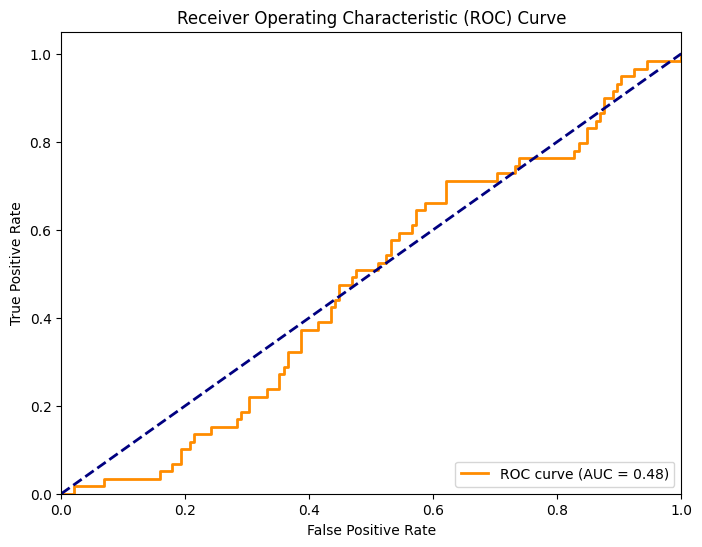

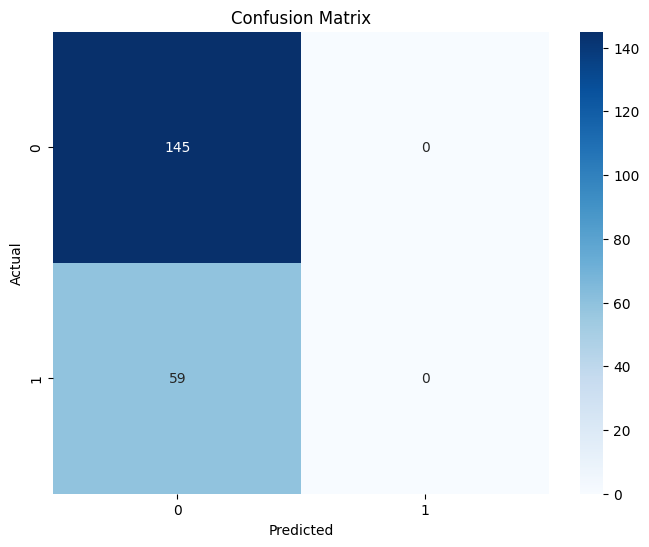

Model Accuracy: 71.08%


In [15]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc
from torchvision.utils import make_grid
import cv2
from scipy import ndimage

class GlaucomaVisualizer:
    def __init__(self, model, dataloader, device):
        self.model = model
        self.dataloader = dataloader
        self.device = device
        
    def plot_roc_curve(self):
        """Plot ROC curve for model evaluation"""
        self.model.eval()
        all_labels = []
        all_predictions = []
        
        with torch.no_grad():
            for images, labels in self.dataloader:
                images = images.to(self.device)
                outputs = self.model(images)
                predictions = torch.sigmoid(outputs)
                
                all_labels.extend(labels.cpu().numpy())
                all_predictions.extend(predictions.cpu().numpy())
        
        fpr, tpr, _ = roc_curve(all_labels, all_predictions)
        roc_auc = auc(fpr, tpr)
        
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2, 
                label=f'ROC curve (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc="lower right")
        plt.show()
        
    def plot_confusion_matrix(self):
        """Plot confusion matrix"""
        self.model.eval()
        all_labels = []
        all_predictions = []
        
        with torch.no_grad():
            for images, labels in self.dataloader:
                images = images.to(self.device)
                outputs = self.model(images)
                predictions = (torch.sigmoid(outputs) > 0.5).float()
                
                all_labels.extend(labels.cpu().numpy())
                all_predictions.extend(predictions.cpu().numpy())
        
        cm = confusion_matrix(all_labels, all_predictions)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix')
        plt.show()
        
    def visualize_attention_maps(self, image_path):
        """Visualize attention maps for a single image"""
        # Load and preprocess image
        image = preprocess_image(image_path)
        image_tensor = torch.tensor(image).permute(2, 0, 1).unsqueeze(0).to(self.device)
        
        self.model.eval()
        with torch.no_grad():
            # Get attention weights from the ViT
            attentions = self.model.encoder.get_attention_map(image_tensor)
            
            # Average attention across heads
            attention_map = attentions.mean(1).mean(1)  # Average across heads and layers
            attention_map = attention_map.reshape(14, 14)  # Reshape to patch grid
            attention_map = ndimage.zoom(attention_map.cpu().numpy(), 
                                      (16, 16),  # Scale up to image size
                                      order=1)
            
            # Plot original image and attention map
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
            ax1.imshow(cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB))
            ax1.set_title('Original Image')
            ax1.axis('off')
            
            im = ax2.imshow(attention_map, cmap='hot')
            ax2.set_title('Attention Map')
            ax2.axis('off')
            plt.colorbar(im)
            plt.show()

def evaluate_model(model, test_loader, device):
    """Evaluate model performance"""
    model.eval()
    correct = 0
    total = 0
    all_probs = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            predictions = (torch.sigmoid(outputs) > 0.5).float()
            
            total += labels.size(0)
            correct += (predictions == labels).sum().item()
            
            all_probs.extend(torch.sigmoid(outputs).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    accuracy = 100 * correct / total
    return accuracy, all_probs, all_labels

# Usage example:
if __name__ == "__main__":
    # Initialize model and load weights
    model = SimCLR().to(device)
    model.load_state_dict(torch.load("/kaggle/working/simclr_model.pth",weights_only=True))
    
    # Create visualizer
    visualizer = GlaucomaVisualizer(model, test_loader, device)
    
    # Generate visualizations
    visualizer.plot_roc_curve()
    visualizer.plot_confusion_matrix()
    
    # Evaluate model
    accuracy, probs, labels = evaluate_model(model, test_loader, device)
    print(f"Model Accuracy: {accuracy:.2f}%")